# StarDist (2D)

## Usage

[tutorial](https://www.youtube.com/watch?v=Amn_eHRGX5M)

- 2d cell segmentation
- optimization for our own data

## Requirements(Installation)

```
conda create --name cell python=3.8
conda activate cell
python -m pip install stardist
```


In [2]:
# importing required libraries
from PIL import Image
from stardist.models import StarDist2D
import cv2
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt
from imageio.v2 import imread
from skimage import io, filters, morphology, util
import numpy as np

2024-05-17 18:26:38.967881: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# chose a region of interest
image = Image.open("../sample_img/original_image_000001.tiff")
box = (100, 100, 400, 400)
cropped_image = image.crop(box)
cropped_image.save('../sample_img/cropped_example2.tiff')

## Pretrained models


In [96]:
# prints a list of available models
StarDist2D.from_pretrained()

# creates a pretrained model
model = StarDist2D.from_pretrained(
    '2D_paper_dsb2018')

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_paper_dsb2018' for 'StarDist2D'.
Loading network weights from 'weights_last.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.417819, nms_thresh=0.5.


Text(0.5, 1.0, 'prediction + input overlay')

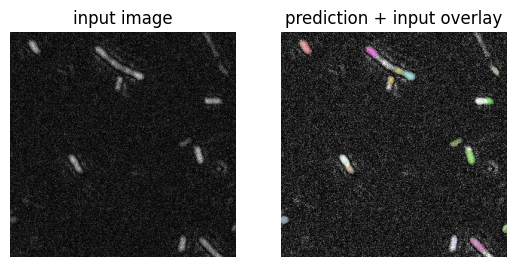

In [99]:
img = imread('../sample_img/filtered_example2.tiff')  # filtered image used

labels, _ = model.predict_instances(normalize(img))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1, 2, 2)
plt.imshow(render_label(labels, img=img))
plt.axis("off")
plt.title("prediction + input overlay")

the pertrained model does not work well for this dataset?
why?:
- background color -> **filter**
- pretrained model not suitable 
- E.coli. may not be star-convex

### Filter

[[50 50 50 ... 50  0  0]
 [50  0  0 ... 50 50 50]
 [50 50 50 ... 50 50 50]
 ...
 [50  0  0 ... 50  0 50]
 [ 0 50  0 ...  0  0 50]
 [50 50  0 ...  0 50 50]]


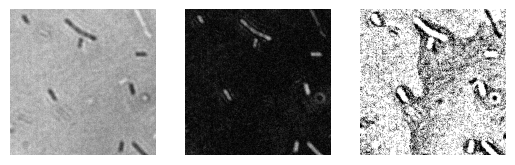

In [55]:
# Read the image in grayscale
gray_image = cv2.imread(
    '../sample_img/cropped_example2.tiff', cv2.IMREAD_GRAYSCALE)

# Apply adaptive thresholding
background = cv2.adaptiveThreshold(
    gray_image, np.max(gray_image),
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    81, 0
)
print(background)

# # Optional: Apply morphological operations to remove noise and small objects
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
# cleaned_image = cv2.morphologyEx(
#     background , cv2.MORPH_OPEN, kernel, iterations=2)

mean_val = cv2.mean(gray_image)[0]

alpha = 0.8

test_image = np.abs(gray_image - mean_val)

background = alpha*background + (1-alpha)*mean_val

range_size = 100
thresholded_image = np.maximum(
    np.abs(gray_image - background) - range_size, 0)

blur_image = cv2.bilateralFilter(gray_image, 3, 75, 75)

laplacian = cv2.Laplacian(blur_image, cv2.CV_64F)

range_size = 20
res_image = np.maximum(np.abs(gray_image - blur_image) - range_size, 0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(gray_image, cmap='gray')
ax1.axis('off')
ax2.imshow(test_image, cmap='gray')
ax2.axis('off')
ax3.imshow(background, cmap='gray')
ax3.axis('off')
plt.show()

In [23]:
# TODO: wrap in a function
# Read the image in grayscale
gray_image = io.imread('../sample_img/cropped_example2.tiff', as_gray=True)

# Apply adaptive thresholding
background = filters.threshold_local(
    gray_image, block_size=81, method='median', offset=0)

# background = filters.threshold_sauvola(
#     gray_image, window_size=81, k=0.2, r=None)

# max_val = np.max(gray_image)
# min_val = np.min(gray_image)
mean_val = cv2.mean(gray_image)[0]
# print("Min value is:", min_val, "Max value is:",
#       max_val, "Mean value is:", mean_val)

alpha = 0.8

test_image = np.abs(gray_image - mean_val)

background = alpha*background + (1-alpha)*mean_val

range_size = 100
thresholded_image = np.maximum(
    np.abs(gray_image - background) - range_size, 0)

# Optional: Apply morphological operations to clean up the image

# # Since the skimage functions expect boolean images, convert to uint8 before saving
# final_image = util.img_as_ubyte(cleaned_image)

In [61]:
# Ensure values are within 0-255
float_thresholded_image = (thresholded_image - np.min(thresholded_image))/(
    np.max(thresholded_image) - np.min(thresholded_image))
int_thresholded_image = util.img_as_ubyte(float_thresholded_image)
cleaned_image = morphology.remove_small_objects(
    int_thresholded_image, min_size=64)

(-0.5, 299.5, 299.5, -0.5)

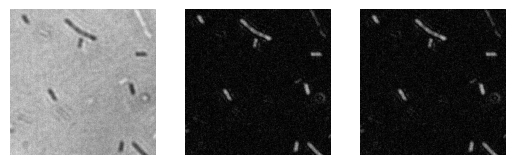

In [62]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(gray_image, cmap='gray')
ax1.axis('off')
ax2.imshow(int_thresholded_image, cmap='gray')
ax2.axis('off')
ax3.imshow(thresholded_image, cmap='gray')
ax3.axis('off')

In [98]:

# Save the result
io.imsave('../sample_img/filtered_example2.tiff', test_image)

## Training

see: [colab](https://colab.research.google.com/github/stardist/stardist/blob/master/extras/stardist_example_2D_colab.ipynb#scrollTo=sEU15_9zSf6d)
